## Import and set root

In [109]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
import math
import time
import os
import pandas as pd
from sklearn import metrics

import bayesian_lib
import preprocessing_lib

import importlib
importlib.reload(bayesian_lib)
importlib.reload(preprocessing_lib)

%matplotlib inline

In [2]:
folder_path = r'C:\Users\natch\Github\Cocoa_Project\Cocoa_Project'
os.chdir(folder_path)

## Bayesian Model

### Select Region of Interest

Text(0.5, 1.0, 'Cut')

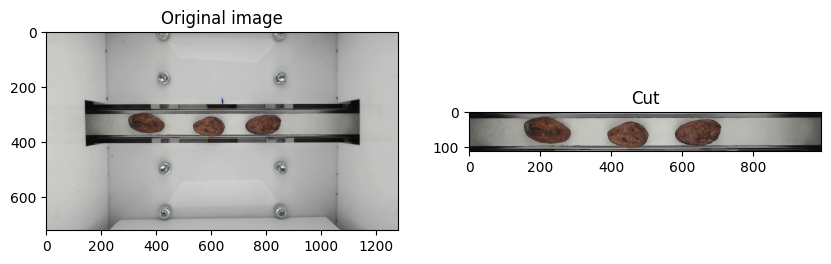

In [3]:
image_test = cv2.imread('./dataset/collect_03072023/data/l/l_1.png')
image_rgb = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, 2, figsize=(2*5, 5))

ax[0].imshow(image_rgb)
ax[0].set_title('Original image')
ax[1].imshow(image_rgb[280:-330, 144:-144, :])
ax[1].set_title('Cut')

### Fit model

In [6]:
# folder_path = r'C:\Users\natch\Github\Cocoa_Project\Basyesian_image'
# os.chdir(folder_path)
annotation_file_path = './dataset/annotation/annotation_test5.json'
raw_image_folder = './dataset/raw/'
name_features = ['B', 'G', 'R', 'Y', 'Cr', 'Cb']

BS_model_rgb = bayesian_lib.Bayesian_Segmentation(n_features=6, name_features=name_features)
BS_model_rgb.fit(raw_image_folder, annotation_file_path, RoI=[280, 330, 144, 144], mode='combine')

Complete Fit data -------------
Detail
------------------------------------------------
Mode: combine
Number of images: 6
Number of Feature: 6 -> ['B', 'G', 'R', 'Y', 'Cr', 'Cb']
------------------------------------------------
Probability of Cocoa:		0.1624908357771261
Probability of Back ground:	0.8375091642228739
------------------------------------------------
Number of cocao sample:		106130
Number of background sample:	548590
Number of shadow sample:	0
Number of fit sample:		106130
------------------------------------------------
Model Background
	B 	mean: 0.4768365471129561 	std: 0.20509737599827102
	G 	mean: 0.48954874063071 	std: 0.21012137263338473
	R 	mean: 0.4927057641109775 	std: 0.2089146908334581
	Y 	mean: 0.4892818093976495 	std: 0.2092103020563477
	Cr 	mean: 0.5048427474259279 	std: 0.005149801874681806
	Cb 	mean: 0.49554652728895193 	std: 0.0054784546909649205
------------------------------------------------
Model Cocoa
	B 	mean: 0.18572294799385883 	std: 0.054602826462

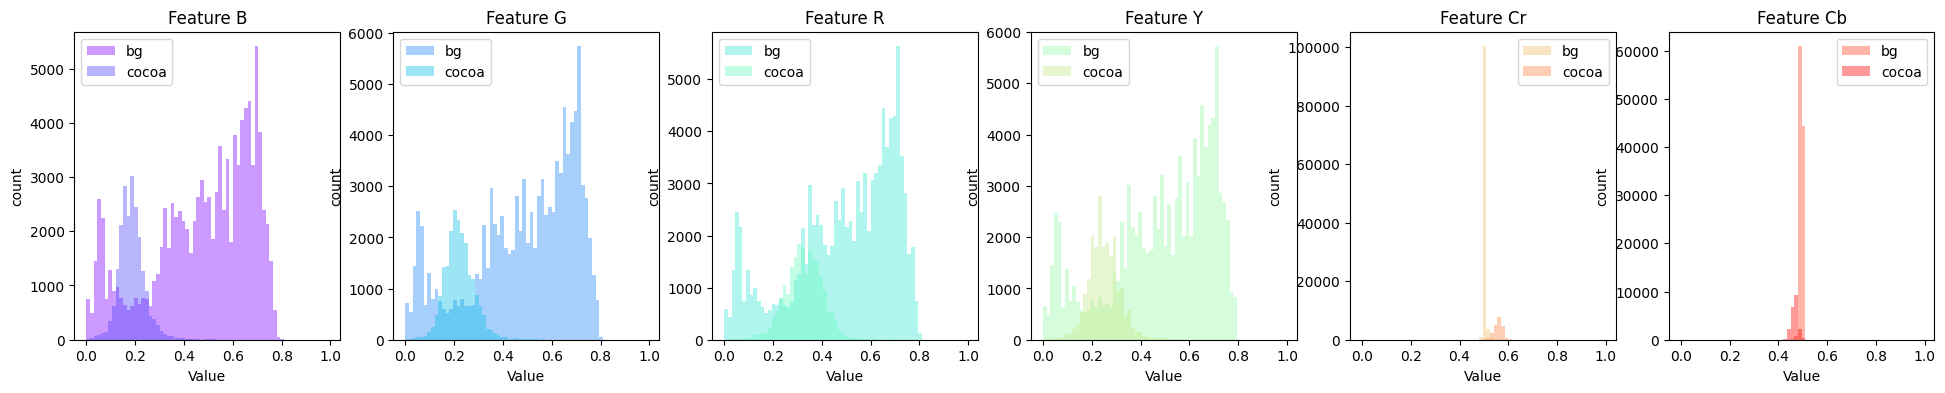

In [7]:
BS_model_rgb.plot_features_distribution(attr=['cocoa', 'bg'])

### Save obj model and load

In [8]:
model_segmentation_savepath = './Basyesian_image/config_setup/model_segmentation.pkl'
bayesian_lib.save_bayesian_obj(model_segmentation_savepath, BS_model_rgb)

Object successfully saved to "./Basyesian_image/config_setup/model_segmentation.pkl"


In [9]:
model_segmentation_loadpath = './Basyesian_image/config_setup/model_segmentation.pkl'
segmentaion_model = bayesian_lib.load_bayesian_obj(model_segmentation_loadpath)

Object successfully loaded "./Basyesian_image/config_setup/model_segmentation.pkl"


### Test and Select weight and threshold

Text(0.5, 1.0, 'Apply')

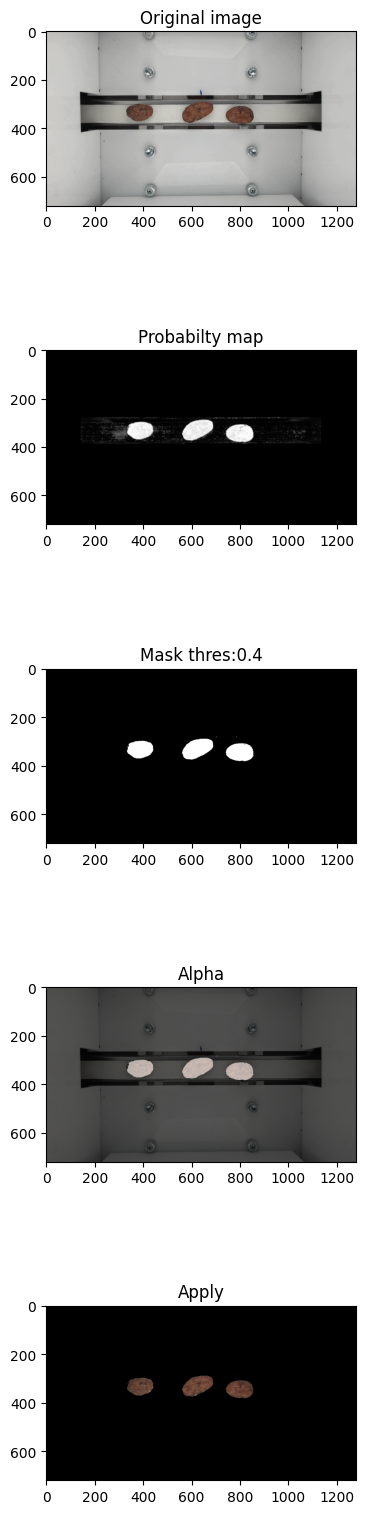

In [49]:
threshold = 0.4
RoI = [280, 330, 144, 144]
weight = [0.1, 0.1, 0, 0.2, 0.4, 0.3]
filter = True

image_test = cv2.imread('./dataset/collect_03072023/data/l/l_5.png')
image_stack = np.zeros((image_test.shape[0], image_test.shape[1], 6))

image_stack[:,:,:3] = image_test
image_stack[:,:,3:6] = cv2.cvtColor(image_test, cv2.COLOR_BGR2YCR_CB)

mask, prob = segmentaion_model.predict(image_stack, weight, threshold=threshold, RoI=RoI, filter=filter)

image_rgb = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
mask_reapeat = np.repeat((mask*255).astype(np.uint8), 3, axis=1).reshape(image_rgb.shape)
mask_apply = cv2.bitwise_and(image_rgb, mask_reapeat)
mask_alpha = cv2.addWeighted(mask_reapeat, 0.6 , image_rgb, 0.4, 0)

fig, ax = plt.subplots(5, 1, figsize=(4, 4*5))
ax[0].imshow(image_rgb)
ax[0].set_title('Original image')

ax[1].imshow(prob, cmap='gray')
ax[1].set_title('Probabilty map')

ax[2].imshow(mask, cmap='gray')
ax[2].set_title('Mask thres:{}'.format(threshold))

ax[3].imshow(mask_alpha)
ax[3].set_title('Alpha')

ax[4].imshow(mask_apply)
ax[4].set_title('Apply')

# Separate beans and Analysis

In [83]:
threshold = 0.4
RoI = [280, 330, 144, 144]
weight = [0.1, 0.1, 0, 0.2, 0.4, 0.3]

In [84]:
folder_path = r'C:\Users\natch\Github\Cocoa_Project\Cocoa_Project\dataset\statistic_analysis3\train'
os.chdir(folder_path)
sub_folder = os.listdir(folder_path)
prep = preprocessing_lib.Prep_cocoa(500) #change kernel

collect = [[] for i in range(len(sub_folder))]
count_bean = [[] for i in range(len(sub_folder))]
collect_mask = [[] for i in range(len(sub_folder))]
collect_name = [[] for i in range(len(sub_folder))]

for i, f in enumerate(sub_folder):
    images = os.listdir(os.path.join(folder_path, f))

    for im in images:
        im_path = os.path.join(folder_path, f, im)
        image_test = cv2.imread(im_path)

        image_stack = np.zeros((image_test.shape[0], image_test.shape[1], 6))

        image_stack[:,:,:3] = image_test
        image_stack[:,:,3:6] = cv2.cvtColor(image_test, cv2.COLOR_BGR2YCR_CB)

        mask, prob = BS_model_rgb.predict(image_stack, weight, threshold=threshold, RoI=RoI, filter=True)

        image_rgb = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)

        sep_mask = prep.crop(mask, RoI=RoI, Horizon=True)
        count_bean[i].append(sep_mask.shape[0])
        collect_mask[i].append(mask)
        collect_name[i].append(im)

        for b in sep_mask:
            collect[i].append(b)

folder_path = r'C:\Users\natch\Github\Cocoa_Project\Cocoa_Project'
os.chdir(folder_path)

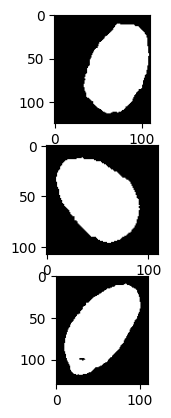

In [85]:
cl = 1
pic_set = 2
start_pic = np.sum(count_bean[cl][:pic_set])
stop_pic = start_pic + count_bean[cl][pic_set]

fig, ax = plt.subplots(count_bean[cl][pic_set], 1)
for i, b in enumerate(collect[cl][start_pic:stop_pic]):
    ax[i].imshow(b, cmap='gray')

plt.show()

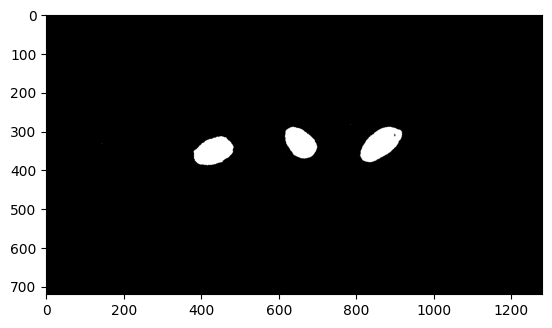

In [86]:
plt.imshow(collect_mask[cl][pic_set], cmap='gray')
plt.show()

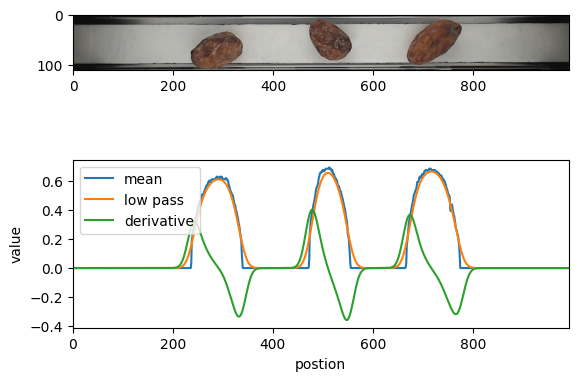

In [87]:
img_rgb = cv2.imread('./dataset/statistic_analysis3/train/'+collect_name[cl][pic_set][0]+'/'+ collect_name[cl][pic_set])
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
prep.plot(img_rgb, collect_mask[cl][pic_set], RoI=RoI, Rot=False)

## Analysis distribution
L / M / S / out

In [88]:
class_sum = [[] for i in range(len(collect_mask))]
for c in range(len(collect_mask)):
    class_sum[c] = [np.sum(m) for m in collect[c]]

collect_mean = [np.mean(np.array(e)) for e in class_sum]
collect_std = [np.std(np.array(e)) for e in class_sum]

In [89]:
for i, c in enumerate(sub_folder):
    print('size {}: \tmean {:.2f} \tstd {:.2f} \tsamples {}'.format(c, collect_mean[i], collect_std[i], np.sum(count_bean[i])))


size l: 	mean 6563.23 	std 787.95 	samples 75
size m: 	mean 5680.28 	std 560.41 	samples 75
size s: 	mean 5251.15 	std 476.62 	samples 75
size z: 	mean 4532.47 	std 727.66 	samples 75


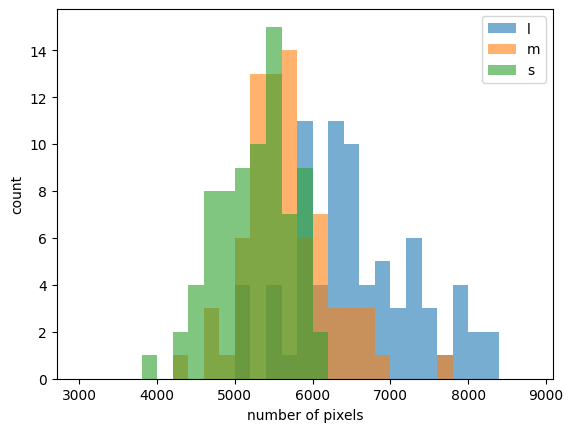

In [90]:
labels = sub_folder
bins = np.arange(3000, 9000, 200)
for i in range(3):
    plt.hist(class_sum[i], alpha=0.6, label=labels[i], bins=bins)

plt.xlabel('number of pixels')
plt.ylabel('count')
plt.legend()

## Predict class

In [108]:
folder_path = r'C:\Users\natch\Github\Cocoa_Project\Cocoa_Project\dataset\statistic_analysis3\test'
os.chdir(folder_path)

sub_folder = os.listdir(folder_path)
prep = preprocessing_lib.Prep_cocoa(500) #change kernel

df = pd.DataFrame(columns=['id', 'number of pixels', 'mask', 'full mask', 'ground truth', 'Rank Probability', 'Postion', 'Predicted'])

for i, f in enumerate(sub_folder):
    images = os.listdir(os.path.join(folder_path, f))

    for im in images:
        im_path = os.path.join(folder_path, f, im)
        image_test = cv2.imread(im_path)

        image_stack = np.zeros((image_test.shape[0], image_test.shape[1], 6))

        image_stack[:,:,:3] = image_test
        image_stack[:,:,3:6] = cv2.cvtColor(image_test, cv2.COLOR_BGR2YCR_CB)

        mask, prob = BS_model_rgb.predict(image_stack, weight, threshold=threshold, RoI=RoI, filter=True)

        sep_mask = prep.crop(mask, RoI=RoI, Horizon=True)

        for id, b in enumerate(sep_mask):
            sum_pixel = np.sum(b)
            bean_id = '{}_{}'.format(im[:-4], id)
            new_row = [bean_id, sum_pixel, b, mask, f]
            probability_class = {'l': 0, 'm': 0, 's': 0, 'z': 0}
            for ic, c in enumerate(sub_folder):
                probability_class[c] = math.e**((((sum_pixel-collect_mean[ic])/collect_std[ic])**2)*(-0.5))

            sorted_probability_class = dict(sorted(probability_class.items(), key=lambda x:x[1], reverse=True))
            new_row.append(sorted_probability_class)
            new_row.append(list(sorted_probability_class.keys()).index(f))
            new_row.append(list(sorted_probability_class.keys())[0])

            df.loc[len(df)] = new_row

excel_savepath = '../stat_test.xlsx'
with pd.ExcelWriter(excel_savepath) as writer:  
    df.to_excel(writer, )

folder_path = r'C:\Users\natch\Github\Cocoa_Project\Cocoa_Project'
os.chdir(folder_path)

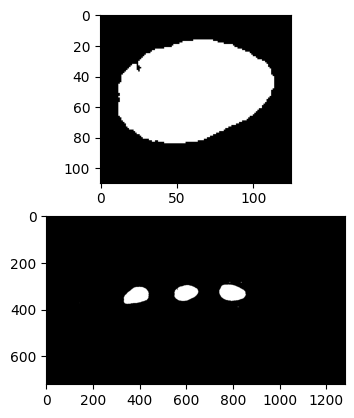

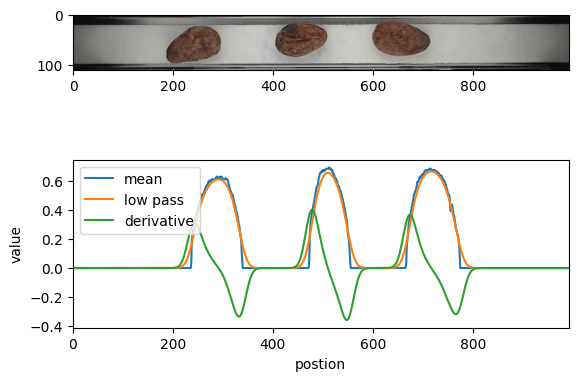

In [134]:
fig, ax = plt.subplots(2, 1)
idx = 88

name = df.loc[idx]['id'][:-2]

img_rgb = cv2.imread('./dataset/statistic_analysis3/test/'+df.loc[idx]['id'][0]+'/'+name+'.png')
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)

ax[0].imshow(df.loc[idx]['mask'].T, cmap='gray')
ax[1].imshow(df.loc[idx]['full mask'], cmap='gray')
plt.show()

prep.plot(img_rgb, collect_mask[cl][pic_set], RoI=RoI, Rot=False)

### Confusion Matrix

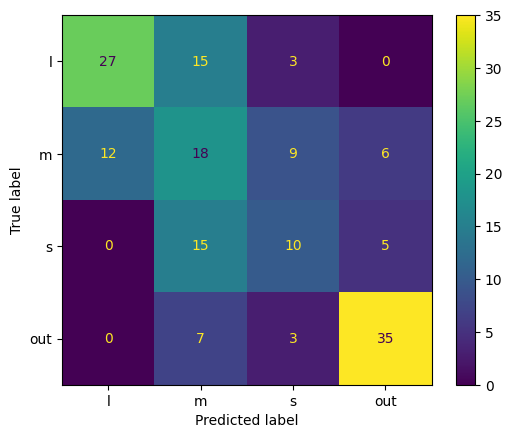

In [122]:
actual = df.loc[:, 'ground truth']
predicted = df.loc[:, 'Predicted']

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['l', 'm', 's', 'out'])

cm_display.plot()
plt.show()

# Additional 

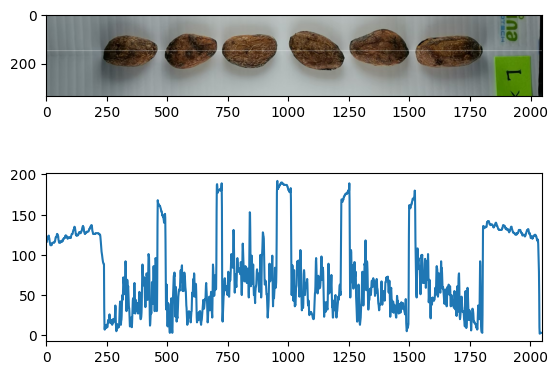

In [226]:
image_test = cv2.imread('../dataset/raw/LINE_ALBUM_Cocoa Beans separated by Weight Range - 2023-04-06_230607_10.jpg')
line = 750

image_ycbcr  = cv2.cvtColor(cv2.rotate(image_test, cv2.ROTATE_90_CLOCKWISE), cv2.COLOR_BGR2YCR_CB)
Y_ch = image_ycbcr[line, :, 0]

image_rgb = cv2.cvtColor(cv2.rotate(image_test, cv2.ROTATE_90_CLOCKWISE), cv2.COLOR_BGR2RGB)
image_rgb[line, :, :] = np.ones((image_rgb.shape[1], 3))*255
image_rgb = image_rgb[600:-600, :]

fig, ax = plt.subplots(2, 1)
ax[0].imshow(image_rgb)
ax[1].plot(Y_ch)
ax[1].set_xlim(xmin=0, xmax=image_rgb.shape[1])

plt.show()

# VDO

## Setup camera

In [ ]:
video = cv2.VideoCapture(1, cv2.CAP_DSHOW)

h = 720
w = 1280

video.set(cv2.CAP_PROP_FRAME_WIDTH, w)
video.set(cv2.CAP_PROP_FRAME_HEIGHT, h)

bold = 1
length = 20
offset = 50

half_h = int(math.floor(h/2))
half_w = int(math.floor(w/2))

while(True):
    start_time = time.time()
    check, frame = video.read()
    #draw center reference
    frame[half_h-length+1:half_h+length, half_w-bold+1:half_w+bold,:] = (0,0,255) #vertical line
    frame[half_h-bold+1:half_h+bold, half_w-length+1:half_w+length,:] = (0,0,255) #horizontal line
    #draw conveyor line reference
    frame[half_h-bold+1-offset:half_h+bold-offset, :,:] = (0,0,255) #over horizontal line
    frame[half_h-bold+1+offset:half_h+bold+offset, :,:] = (0,0,255) #under horizontal line

    cv2.imshow("Setup", frame)

    if cv2.waitKey(30) & 0xFF == ord('q'):
        cv2.destroyWindow("Setup")
        break
     
video.release()

## Distrotion Fixing

In [46]:
h = 720
w = 1280

logi_camera = preprocessing_lib.Camera(1, w, h)

In [47]:
logi_camera.camera_calculate_intrinsic_param(10, 3, 20, save_file_path='./parameter/camera_calibration.yaml')

1
2
3
4
5
6
7
8
9
10
11
12
13
Sucessful Calculate Intrinsic Parameter


In [48]:
logi_camera.load_intrinsic_param('./parameter/camera_calibration.yaml')

In [50]:
logi_camera.Test()

## Capture image

In [3]:
video = cv2.VideoCapture(1, cv2.CAP_DSHOW)

h = 720
w = 1280

video.set(cv2.CAP_PROP_FRAME_WIDTH, w)
video.set(cv2.CAP_PROP_FRAME_HEIGHT, h)

id = 17
save_directory = r"C:\Users\natch\Github\Cocoa_Project\dataset\collect_03072023\train\out"

while(True):
    start_time = time.time()
    check, frame = video.read()
    # gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    cv2.imshow("Capturing", frame)

    if cv2.waitKey(50) & 0xFF == ord('q'):
        cv2.destroyWindow("Capturing")
        break
    
    if cv2.waitKey(50) & 0xFF == ord('c'):
        file_name = os.path.join(save_directory, '{}{}{}'.format('out_', id, '.png'))
        print('Saved!!!', file_name)
        cv2.imwrite(file_name, frame)
        id += 1

video.release()

Saved!!! C:\Users\natch\Github\Cocoa_Project\dataset\collect_03072023\train\out\out_17.png
Saved!!! C:\Users\natch\Github\Cocoa_Project\dataset\collect_03072023\train\out\out_18.png
Saved!!! C:\Users\natch\Github\Cocoa_Project\dataset\collect_03072023\train\out\out_19.png
Saved!!! C:\Users\natch\Github\Cocoa_Project\dataset\collect_03072023\train\out\out_20.png
Saved!!! C:\Users\natch\Github\Cocoa_Project\dataset\collect_03072023\train\out\out_21.png
Saved!!! C:\Users\natch\Github\Cocoa_Project\dataset\collect_03072023\train\out\out_22.png
Saved!!! C:\Users\natch\Github\Cocoa_Project\dataset\collect_03072023\train\out\out_23.png
Saved!!! C:\Users\natch\Github\Cocoa_Project\dataset\collect_03072023\train\out\out_24.png
Saved!!! C:\Users\natch\Github\Cocoa_Project\dataset\collect_03072023\train\out\out_25.png
Saved!!! C:\Users\natch\Github\Cocoa_Project\dataset\collect_03072023\train\out\out_26.png
Saved!!! C:\Users\natch\Github\Cocoa_Project\dataset\collect_03072023\train\out\out_27.png

## Test Model on video

In [64]:
video = cv2.VideoCapture(2)
threshold = 0.7

while(True):
    start_time = time.time()

    check, frame = video.read()
    frame_y = cv2.cvtColor(frame, cv2.COLOR_BGR2YCR_CB)

    image_stack = np.zeros((frame_y.shape[0], frame_y.shape[1], 6))
    image_stack[:,:,:3] = frame
    image_stack[:,:,3:6] = frame_y
    
    mask, pred_image = BS_model_rgb.predict(image_stack, [0.3, 0.2, 0, 0.2, 0.15, 0.15], threshold=threshold, RoI=[200, 200,115, 115], filter=True)

    finish_time = time.time()

    print(finish_time-start_time)

    cv2.imshow("Capturing", pred_image)

    key = cv2.waitKey(1)
    if cv2.waitKey(1) & 0xFF == ord('s'):
        cv2.destroyWindow("Capturing")
        break
    
video.release()